## 1. Image Processing

## 1. Image Processing

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob

from tqdm import tqdm
import skimage
from skimage.transform import resize
from sklearn.utils import shuffle
from skimage.color import rgb2gray

import tensorflow as tf

# 1. Extraction, Separation and Preleminary Preprocessing of the image data

In [ ]:
X = []
y = []

In [ ]:
forest_fire_dataset= "Forest Fire Dataset"

for img in os.listdir(forest_fire_dataset):
            if img in ["fire"]: 
                fire_state = 1
            elif img in ["start_fire"]:
                fire_state = 2
            else:
                fire_state = 0
            for i in tqdm(os.listdir(forest_fire_dataset +"/" +img+"/")):
                fire_img = cv2.imread(forest_fire_dataset + "/" +img + "/" + i)
                if fire_img is not None:
                    # fire_img = rgb2gray(skimage.transform.resize(fire_img,(224,224,3), anti_aliasing=True))
                    fire_img = skimage.transform.resize(fire_img,(224,224,3), anti_aliasing=True)
                    fier_img_arr = np.asarray(fire_img)
                    X.append(fier_img_arr)
                    y.append(fire_state)

100%|██████████| 1071/1071 [01:03<00:00, 16.98it/s]


In [ ]:
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
#X, y = shuffle(X, y)

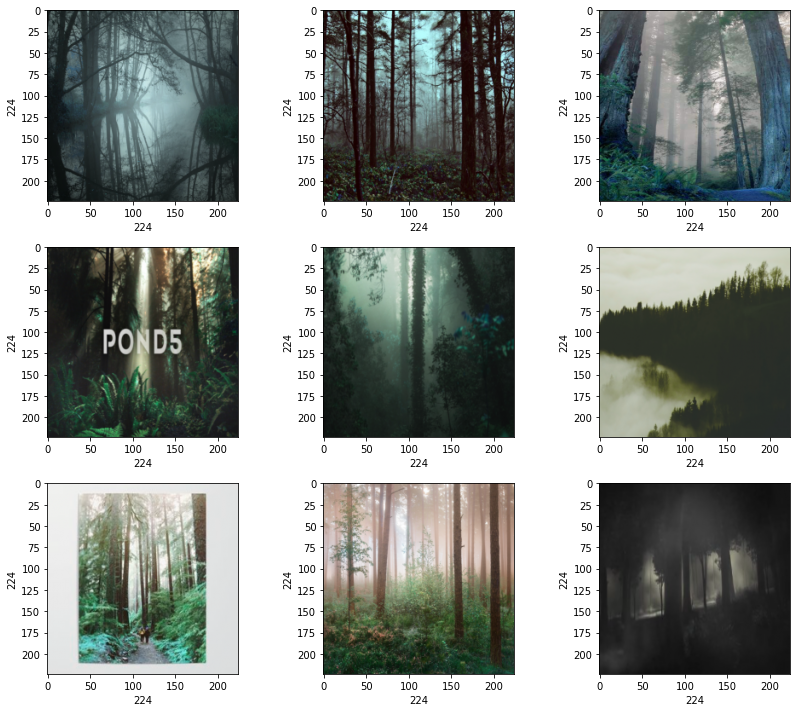

In [ ]:
plt.figure(figsize=(12,10))
a = 1

for img in range(121,130):
  plt.subplot(3,3,a)
  plt.tight_layout()
  plt.imshow(X[img-1])
  plt.xlabel(X[img-1].shape[1], fontsize=10)
  plt.ylabel(X[img-1].shape[0], fontsize=10)
  a = a+1

## Graphical representation of images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  This is separate from the ipykernel package so we can avoid doing imports until


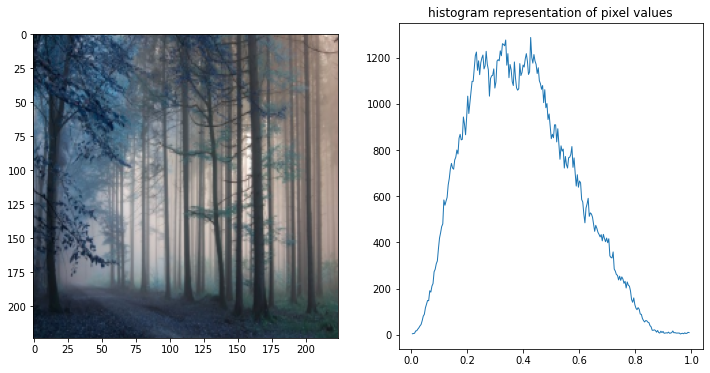

In [ ]:
#Check for pixel intensity distribution in image samples
from skimage.exposure import histogram
h, centers_for_histogram = histogram(X[8])
figure, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow((X[8]), cmap=plt.cm.gray)
axes[1].plot(centers_for_histogram, h, lw=1);
axes[1].set_title('histogram representation of pixel values');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  """Entry point for launching an IPython kernel.


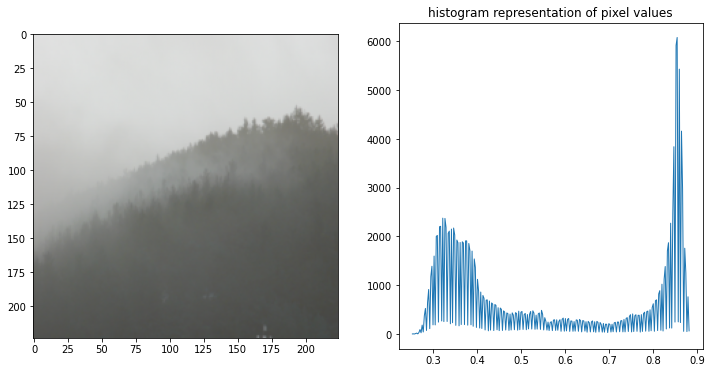

In [ ]:
h, centers_for_histogram = histogram(X[114])
figure, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow((X[114]), cmap=plt.cm.gray)
axes[1].plot(centers_for_histogram, h, lw=1);
axes[1].set_title('histogram representation of pixel values');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  """Entry point for launching an IPython kernel.


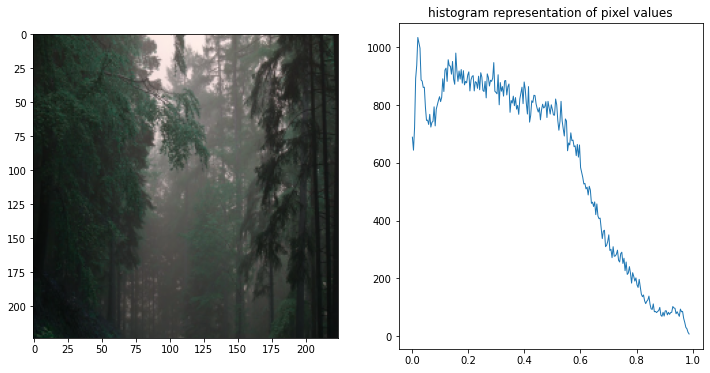

In [ ]:
h, centers_for_histogram = histogram(X[182])
figure, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow((X[18]), cmap=plt.cm.gray)
axes[1].plot(centers_for_histogram, h, lw=1);
axes[1].set_title('histogram representation of pixel values');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  """Entry point for launching an IPython kernel.


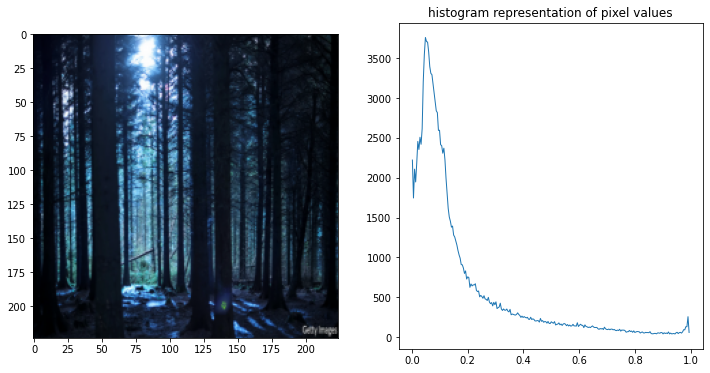

In [ ]:
h, centers_for_histogram = histogram(X[155])
figure, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow((X[155]), cmap=plt.cm.gray)
axes[1].plot(centers_for_histogram, h, lw=1);
axes[1].set_title('histogram representation of pixel values');

# Feature Engineering

Taking a smaller subset of the data to apply different Feature Engineering techniques

In [ ]:
dX = X[0:100]
dy = y[0:100]

## 1. Color Transformation : RGB to LAB

In [ ]:
from skimage.color import rgb2lab, lab2rgb

In [ ]:
lab_X = []

In [ ]:
for img in dX:
  lab_X.append(rgb2lab(img))

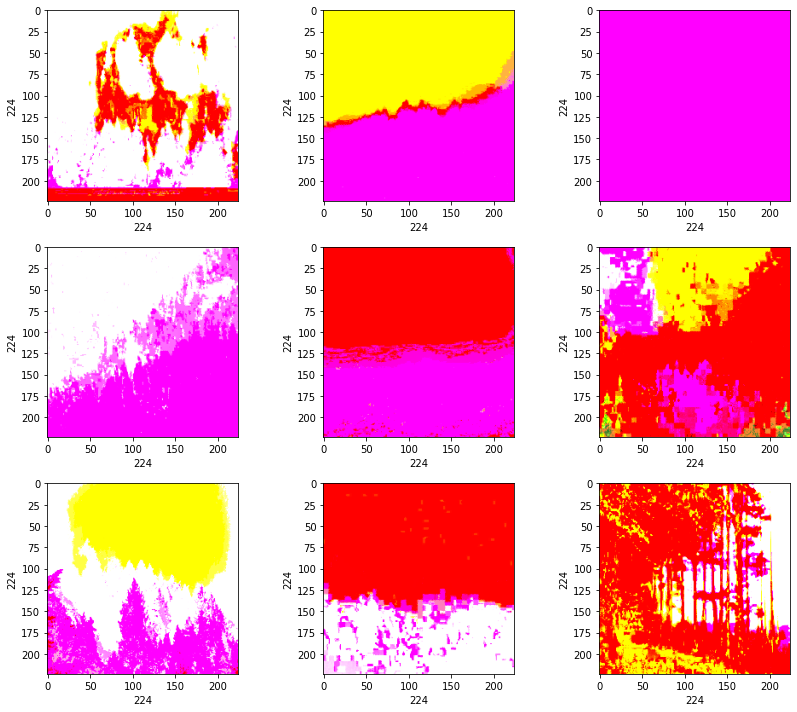

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(lab_X[img-1])
  plt.xlabel(lab_X[img-1].shape[1], fontsize=10)
  plt.ylabel(lab_X[img-1].shape[0], fontsize=10)

## 2. Noise Filtering

**Gaussian Filter**

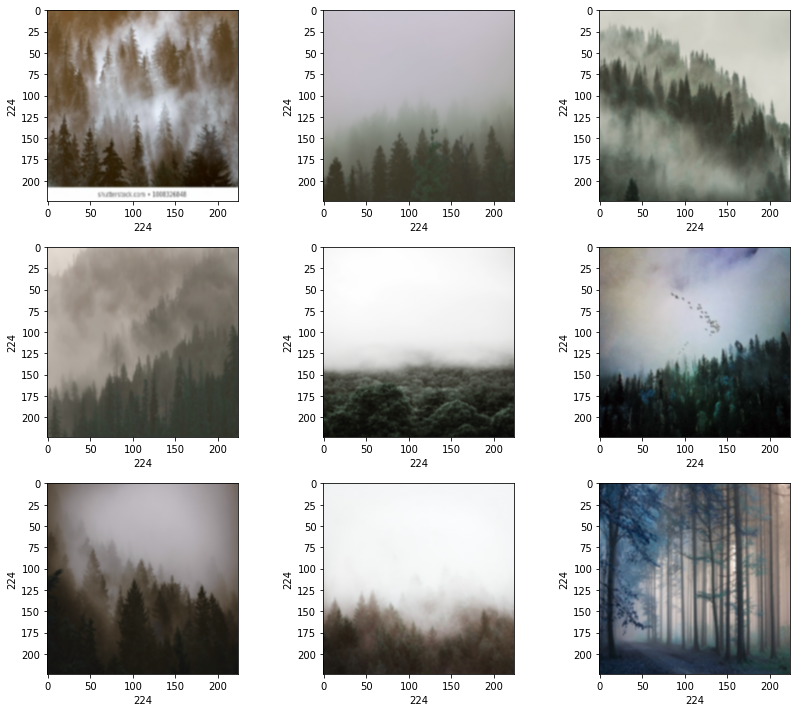

In [ ]:
# Gaussian filter
gf = []

for img in dX:
  gf.append(cv2.GaussianBlur(img, (3,3), 1,1))
  #mf.append(cv2.medianBlur(img, 5))

plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(gf[img-1])
  plt.xlabel(gf[img-1].shape[1], fontsize=10)
  plt.ylabel(gf[img-1].shape[0], fontsize=10)

## 3. Segmentation

In [ ]:
th = []

for img in dX:
  img = img*255
  img = img.astype(np.uint8)
  b,g,r = cv2.split(img)
  rgb_img = cv2.merge([r,g,b])
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # noise removal
  kernel = np.ones((2,2),np.uint8)
  #opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
  closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
  # sure background area
  sure_bg = cv2.dilate(closing,kernel,iterations=3)
  # Finding sure foreground area
  dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
  # Threshold
  ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
  # Marker labelling
  ret, markers = cv2.connectedComponents(sure_fg)
  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1
  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0
  markers = cv2.watershed(img,markers)
  a = img
  a[markers == -1] = [255,0,0]
  th.append(a)

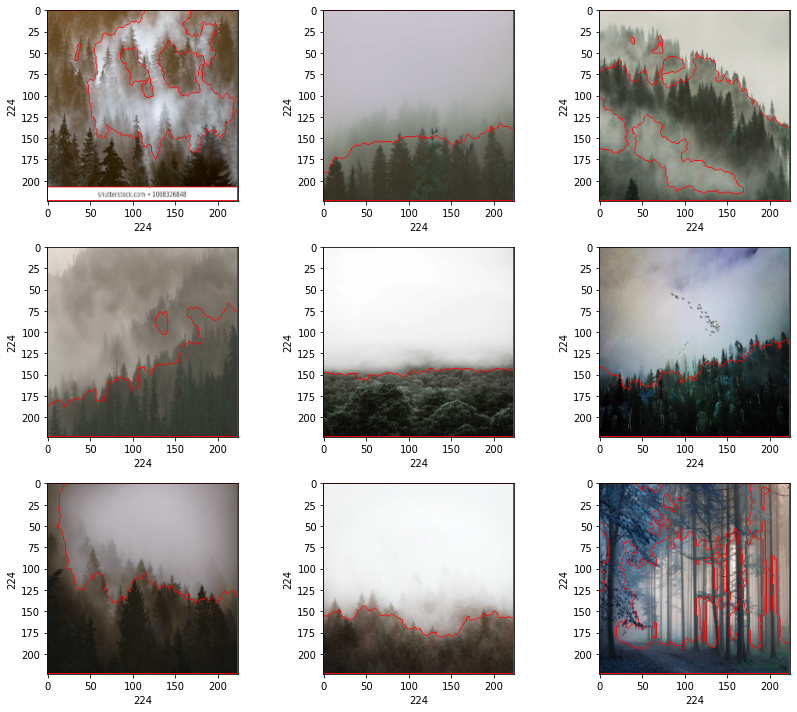

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(th[img-1])
  plt.xlabel(th[img-1].shape[1], fontsize=10)
  plt.ylabel(th[img-1].shape[0], fontsize=10)

## 4. Thresholding

In [ ]:
th1 = []
th2 = []

for img in dX:
  img = img*255
  img = img.astype(np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  th1.append(cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                          cv2.THRESH_BINARY, 199, 5))
  
  th2.append(cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 199, 5))

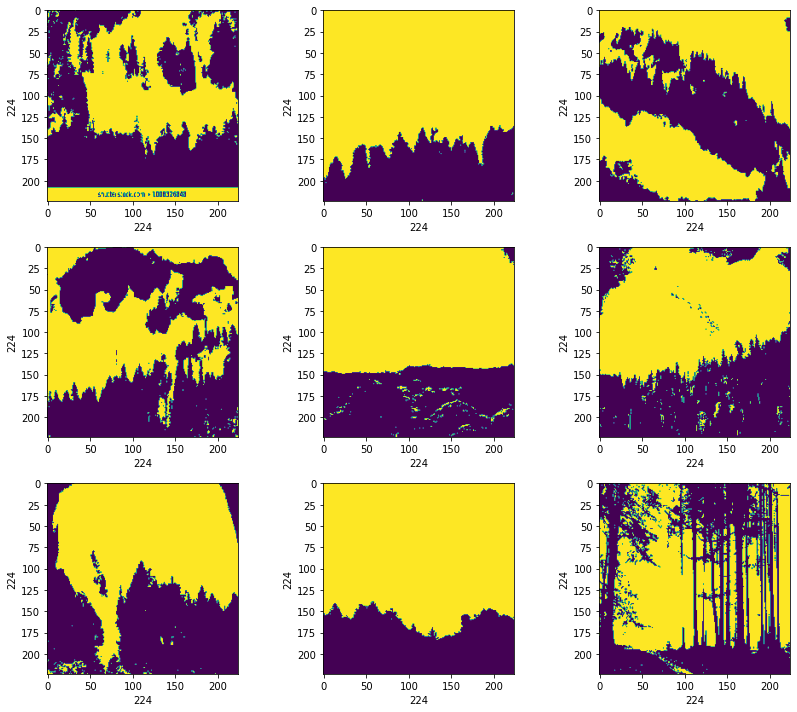

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(th1[img-1])
  plt.xlabel(th1[img-1].shape[1], fontsize=10)
  plt.ylabel(th1[img-1].shape[0], fontsize=10)

# 5. Edge Detection

In [ ]:
sobelx = []
sobely = []
sobelxy = []
edges = []

for img in X:
  img = img*255
  img = img.astype(np.uint8)
  # Convert to graycsale
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Blur the image for better edge detection
  img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
  
  # Sobel Edge Detection
  sobelx.append(cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)) # Sobel Edge Detection on the X axis
  sobely.append(cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)) # Sobel Edge Detection on the Y axis
  sobelxy.append(cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)) # Combined X and Y Sobel Edge Detection
  
  # Canny Edge Detection
  edges.append(cv2.Canny(image=img_blur, threshold1=100, threshold2=200)) # Canny Edge Detection


**Horizontal Edges**

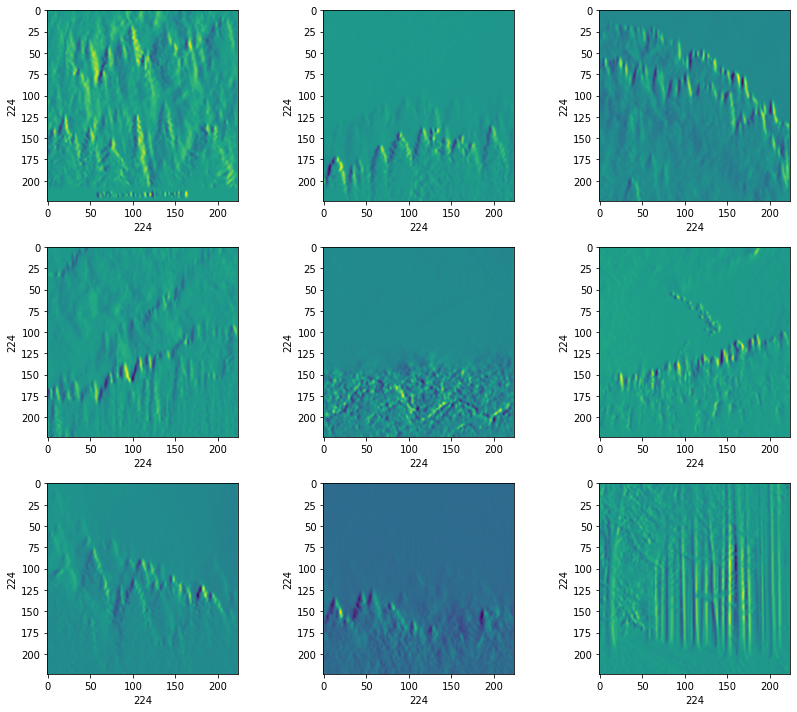

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(sobelx[img-1])
  plt.xlabel(sobelx[img-1].shape[1], fontsize=10)
  plt.ylabel(sobelx[img-1].shape[0], fontsize=10)

**Vertical Edges**

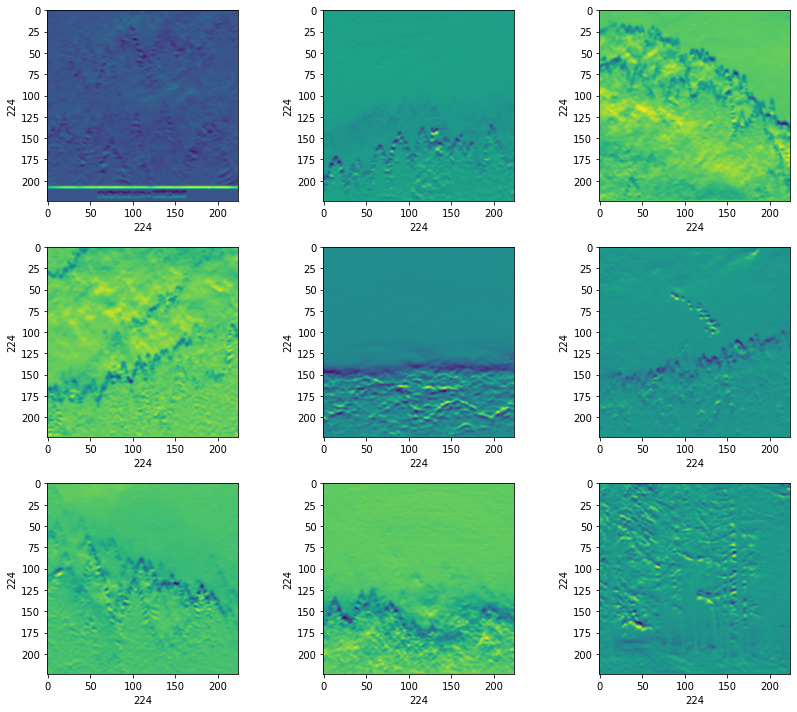

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(sobely[img-1])
  plt.xlabel(sobely[img-1].shape[1], fontsize=10)
  plt.ylabel(sobely[img-1].shape[0], fontsize=10)

**Combined Horizontal and Vertical Edges**

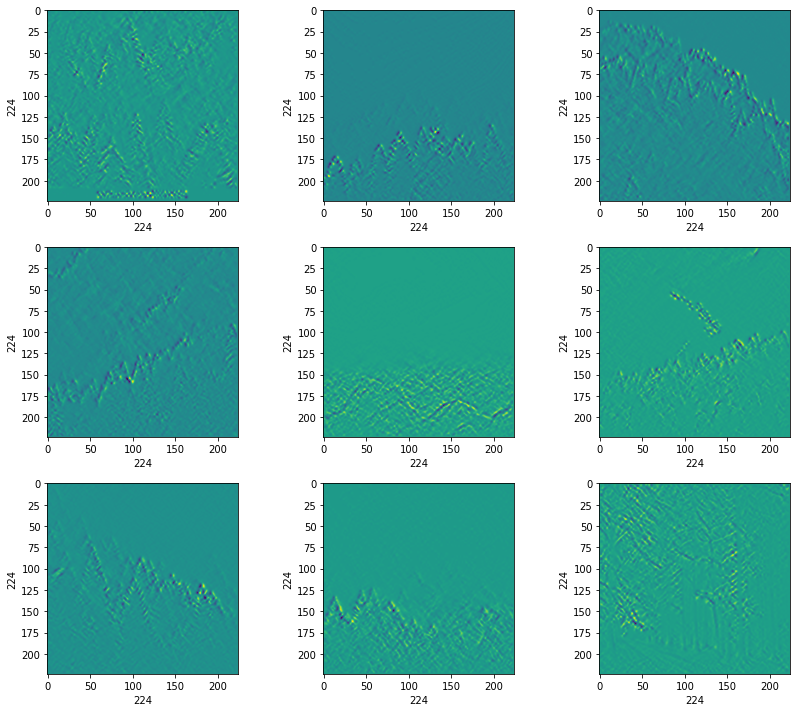

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(sobelxy[img-1])
  plt.xlabel(sobelxy[img-1].shape[1], fontsize=10)
  plt.ylabel(sobelxy[img-1].shape[0], fontsize=10)

**Canny Edge Detetction after applying a Gaussian Filter**

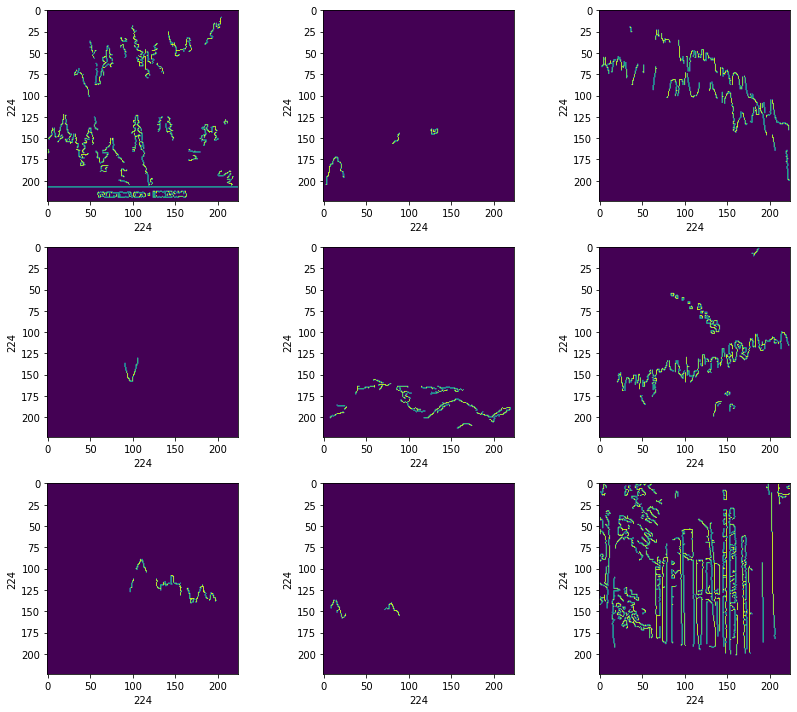

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(edges[img-1])
  plt.xlabel(edges[img-1].shape[1], fontsize=10)
  plt.ylabel(edges[img-1].shape[0], fontsize=10)

## 6. ORB Keypoint Detection

In [ ]:
kp = []
des = []
Xkp = []

for img in X:
  img = img*255
  img = img.astype(np.uint8)
  # Initiate ORB detector
  orb = cv2.ORB_create()
  # find the keypoints with ORB
  kpx = orb.detect(img,None)
  # compute the descriptors with ORB
  kpx, desx = orb.compute(img, kpx)
  kp.append(kpx)
  des.append(desx)
  # draw only keypoints location,not size and orientation
  Xkp.append(cv2.drawKeypoints(img, kpx, None, color=(0,255,0), flags=0))

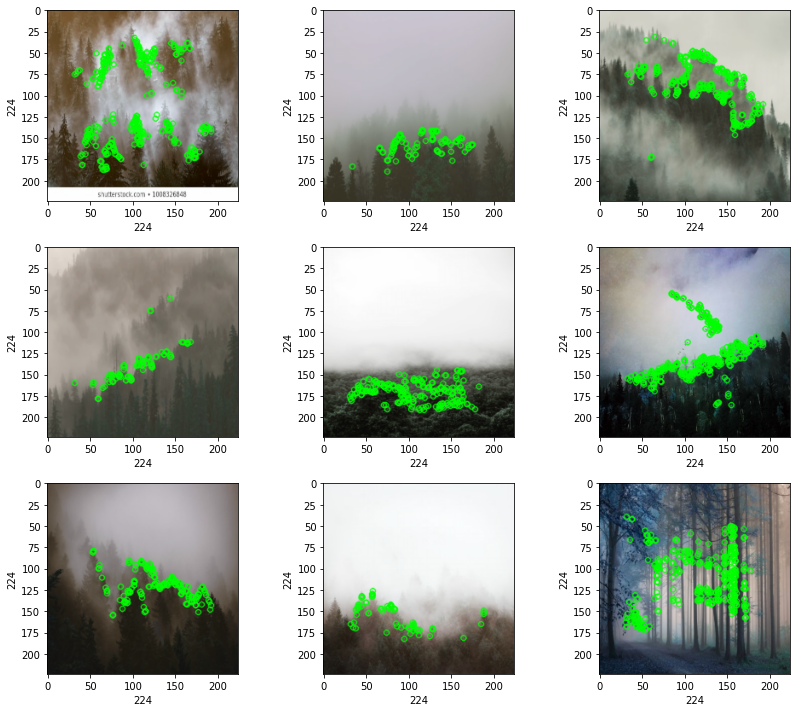

In [ ]:
plt.figure(figsize=(12,10))

for img in range(1,10):
  plt.subplot(3,3,img)
  plt.tight_layout()
  plt.imshow(Xkp[img-1])
  plt.xlabel(Xkp[img-1].shape[1], fontsize=10)
  plt.ylabel(Xkp[img-1].shape[0], fontsize=10)